In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install resampy

import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten,  MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.4 MB/s eta 0:00:00


In [ ]:
import os
audio_files_path = "/content/drive/MyDrive/TrueeTone/Dataset/Sampled Audio"

if os.path.exists(audio_files_path):
  print("Path exists")
else:
  raise FileNotFoundError(audio_files_path, "is not found !!")

folders = os.listdir(audio_files_path)
print(folders)

Path exists
['Fake Sampled', 'Real Sampled']


Real Audio:


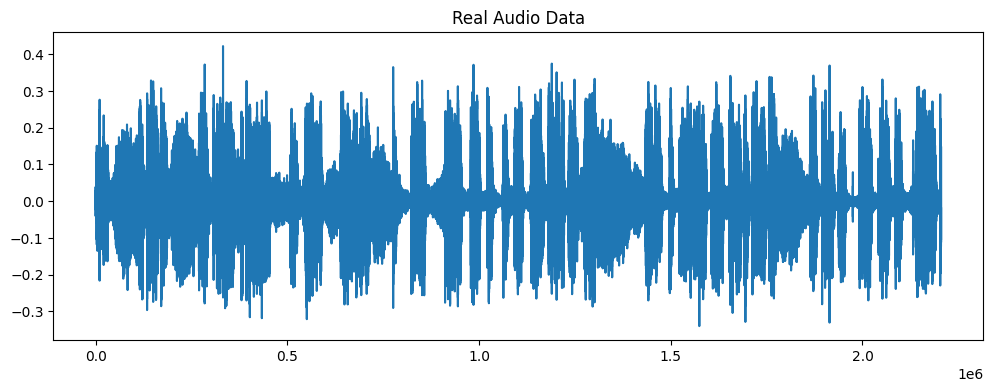

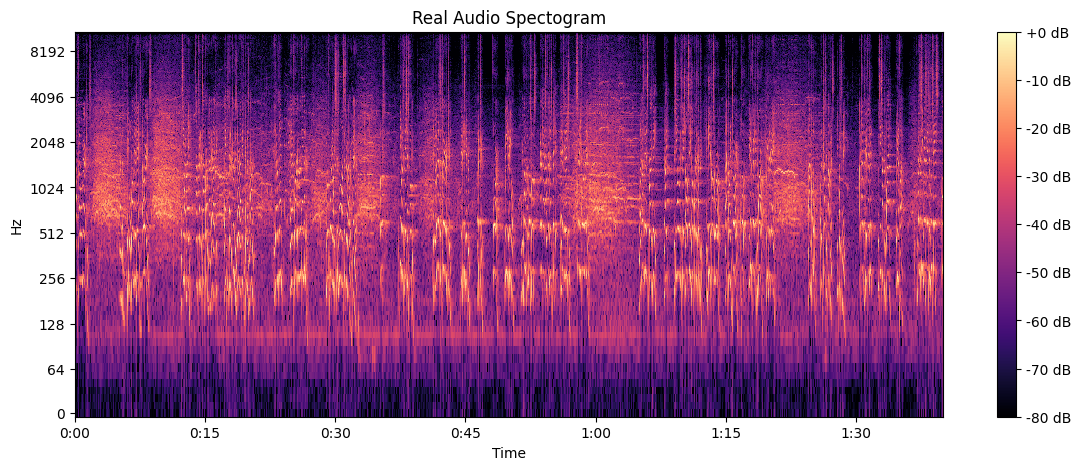

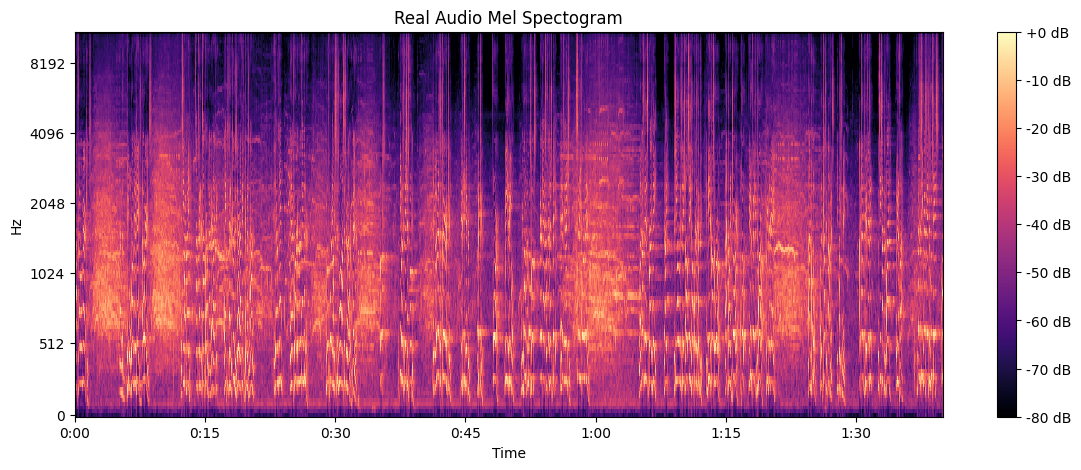

In [3]:
import IPython.display as ipd
print("Real Audio:")

# Real Audio To Listen
real_audio = "/content/drive/MyDrive/TrueeTone/Dataset/Test Audio/Test Real/biden-original_seg_1.wav"
ipd.Audio(filename=real_audio)

#Real Audio Data
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

# Real Audio Spectrum
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()


# Real Audio Mel Spectogram
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()


Fake Audio:


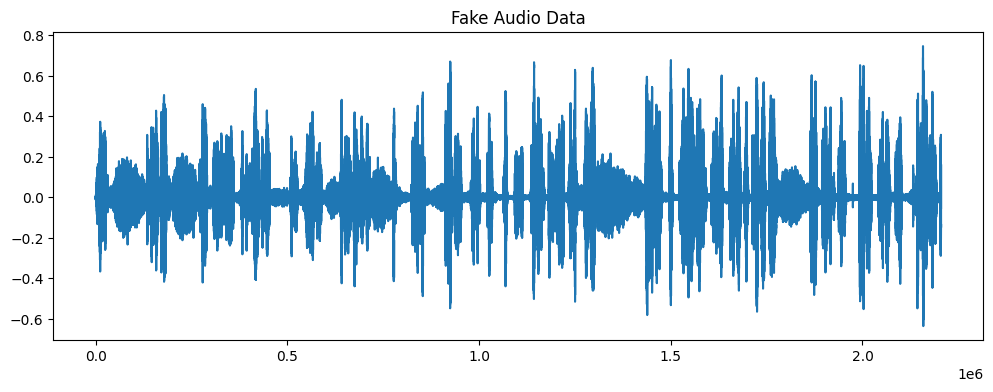

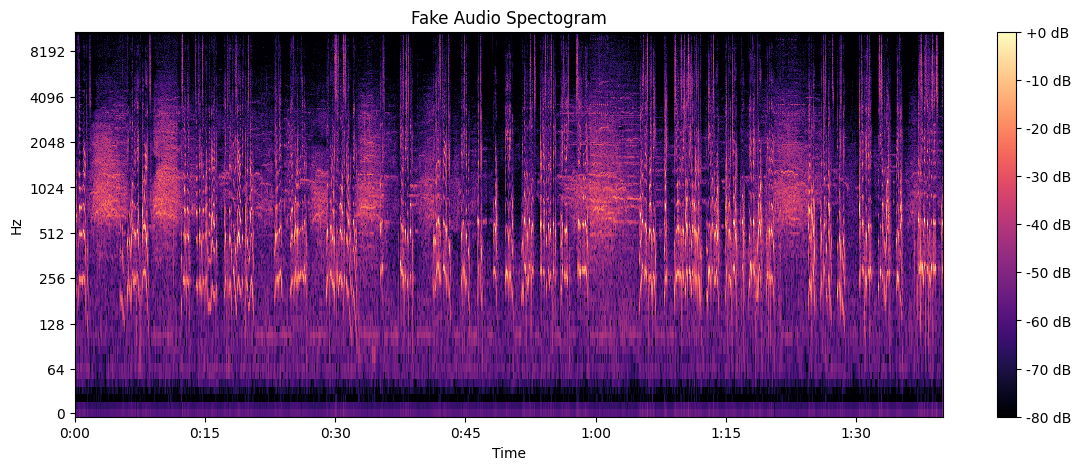

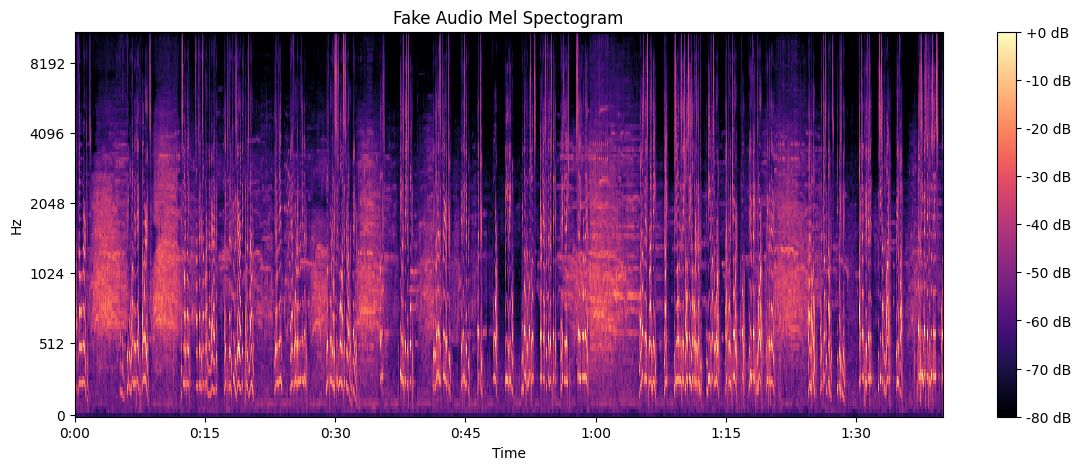

In [4]:
import IPython.display as ipd
fake_audio = "/content/drive/MyDrive/TrueeTone/Dataset/Test Audio/Test Fake/biden-to-Obama_seg_1.wav"
# Fake Audio to listen
print("Fake Audio:")
ipd.Audio(filename=fake_audio)

# Fake Audio Data
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

# Fake Audio Spectogram
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

# Fake Audio Mel Spectogram
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()


In [ ]:
# Pre-processing

data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df["class"] = label_encoder(feature_df["class"])

X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

y_resampled = to_categorical(y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

num_labels = len(feature_df["class"].unique())

input_shape = feature_df["features"][0].shape

100%|██████████| 185/185 [01:14<00:00,  2.48it/s]

class ['Fake Sampled' 'Real Sampled']


In [ ]:
# Model Training CNN
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print("Model Summary: ")
print(model.summary())


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=75, verbose=1 )

model.save('Sampled1_dense_model.h5')

Model Summary: 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,426 (279.01 KB)

 Trainable params: 71,426 (279.01 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/75
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.5048 - loss: 6.9742 - val_accuracy: 0.6255 - val_loss: 0.6620
Epoch 2/75
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5747 - loss: 0.7531 - val_accuracy: 0.6313 - val_loss: 0.6468
Epoch 3/75
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5823 - loss: 0.6814 - val_accuracy: 0.6795 - val_loss: 0.5792
Epoch 4/75
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6367 - loss: 0.6183 - val_accuracy: 0.7606 - val_loss: 0.5028
Epoch 5/75
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7160 - loss: 0.5552 - val_accuracy: 0.9131 - val_loss: 0.2746
Epoch 6/75
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8405 - loss: 0.3746 - val_accuracy: 0.9479 - val_loss: 0.1789
Epoch 7/75
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8992 - loss: 0.2694 - val_accuracy: 0.9710 - val_loss: 0.1308
Epoch 8/75
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9185 - loss: 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0170
Test Loss: 0.01854514330625534
Test Accuracy: 0.9980695247650146


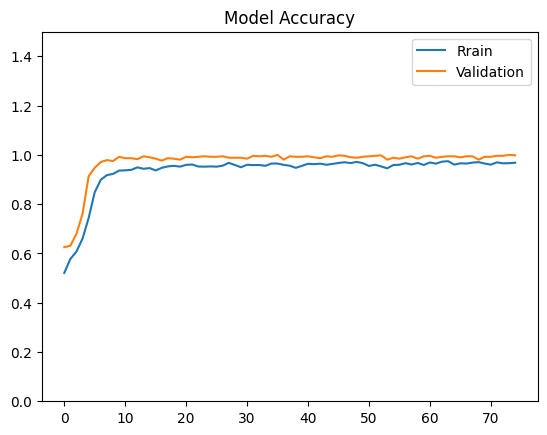

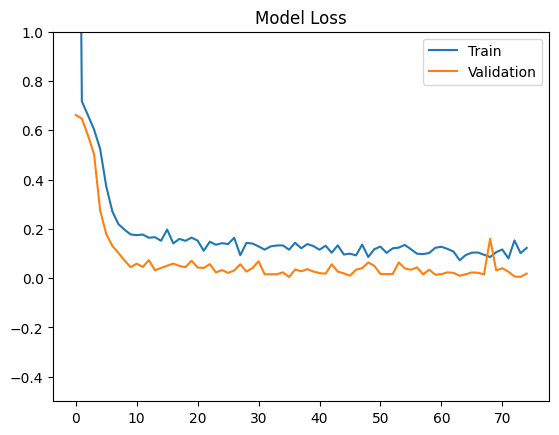

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="Rrain")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.ylim([0, 1.5])
plt.show()

plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.ylim([-0.5, 1])
plt.show()

In [ ]:
import tensorflow as tf

model_extraction = tf.keras.models.load_model("/content/drive/MyDrive/TrueeTone/Training/pre_trained_dense_model.h5")

def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model_extraction.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

test_real = "/content/drive/MyDrive/TrueeTone/Dataset/Test Audio/Test Real/linus-original_seg_4.wav"
test_fake = "/content/drive/MyDrive/TrueeTone/Dataset/Test Audio/Test Fake/linus-to-trump_seg_1.wav"
detect_fake(test_real)
detect_fake(test_fake)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[[0. 1.]]
Result: REAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[1. 0.]]
Result: FAKE
